# Analysis of Beta Series Correlations

This notebook walks through the exploration of beta series correlations extracted from both task and rest data.
The rest data was treated like the task data, that is, any event that happened during the task we pretend the event also happened during rest.

The expectation is that beta series correlations from a task will "look different" from the beta series correlations from rest.
Demonstrating the difference will provide a validity check for [NiBetaSeries](https://nibetaseries.readthedocs.io/en/stable/).

I will attempt to measure the difference between task and rest with multiple approaches.

1. The average within/between network correlations will be different between task and rest
  - specifically I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data.
2. The correlation contrast between task and rest will different from zero.
  - To maximize the potential to detect a difference, subtracting the rest correlation matrix from the task correlation matrix from every participant _should_ result in the greatest possible difference.

**UPDATE:**

The first hypothesis has no visual support, in fact, as you will see the average within network correlation is greater for the resting state data.
The average between network correlation also does not appear to be different between the two.

Since the rest data beta series had more structure than anticipated, a couple graph theoretical measures were added.

3. The participation coefficient for the task data should be closer to 1 relative to the rest data.
   This supports the finding by Wig (2017)
4. Conversly, the clustering coefficient should be lower for the task data relative to the rest data.
5. Modularity should also be lower for the task data

## Settings/Constants
You will probably need to change these settings to have the notebook work for you.

In [1]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# other constants

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_PATH = '../lss/nibetaseries'
LSA_PATH = '../lsa/nibetaseries'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

## Libraries
These are the packages used in this notebook, including `notebook_functions` which isolates some repeated code sections to keep the notebook clearer.

In [2]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from statsmodels.stats.multitest import multipletests
import notebook_functions as nf


In [21]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/nibsAnalysis/notebook_functions.py'>

## Find/Aggregate in the files

pybids is an awesome tool to index and query the data on your computer.
The layout variables contain all the information needed to extract where my correlation files are and what attributes they have (e.g., are they from task or rest, are they from the repeat or switch trial type, etc.)

In [4]:
lss_layout = BIDSLayout('../lss/nibetaseries', validate=False, config=['bids', 'derivatives'])
lsa_layout = BIDSLayout('../lsa/nibetaseries', validate=False, config=['bids', 'derivatives'])

In [5]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/nibsAnalysis/notebook_functions.py'>

In [6]:
fauxbold_switch_objs = lss_layout.get(
    suffix="correlation", extension="tsv", task="fauxbold", desc="switch")
taskswitch_switch_objs = lss_layout.get(
    suffix="correlation", extension="tsv", task="taskswitch", desc="switch")

# this participant cannot fit the lss model
taskswitch_switch_filt_objs = [ob for ob in taskswitch_switch_objs if ob.entities['subject'] != 'GE120056']

fauxbold_repeat_objs = lss_layout.get(
    suffix="correlation", extension="tsv", task="fauxbold", desc="repeat")
taskswitch_repeat_objs = lss_layout.get(
    suffix="correlation", extension="tsv", task="taskswitch", desc="repeat")

## 1. Average within/between network correlations for task and rest
I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data, and beta should not have a good fit for the rest data.

In [7]:
# summarize the task data
with Pool(N_THREADS) as p:
    ts_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in taskswitch_switch_objs])
taskswitch_df = pd.concat(ts_dfs)
taskswitch_df.head()

finished GE120027
finished GE120021
finished GE120025
finished GE120036
finished GE120024
finished GE120001
finished GE120034
finished GE120033
finished GE120005
finished GE120006
finished GE120029
finished GE120026
finished GE120015
finished GE120032
finished GE120019
finished GE120023
finished GE120031
finished GE120030
finished GE120035
finished GE120028
finished GE120020
finished GE120018
finished GE120003
finished GE120012
finished GE120010
finished GE120017
finished GE120011
finished GE120004
finished GE120014
finished GE120013
finished GE120008
finished GE120002
finished GE120037
finished GE120040
finished GE120038
finished GE120039
finished GE120041
finished GE120042
finished GE120043
finished GE120044
finished GE120049
finished GE120050
finished GE120045
finished GE120047
finished GE120056
finished GE120054
finished GE120052
finished GE120055
finished GE120059
finished GE120057
finished GE120068
finished GE120060
finished GE120053
finished GE120063
finished GE120061
finished G

,network_connection,source_network,mean,participant_id
0,between,ContA,0.136585,GE120001
1,between,ContB,0.096565,GE120001
2,between,ContC,0.055755,GE120001
3,between,DefaultA,0.030726,GE120001
4,between,DefaultB,0.105533,GE120001


In [8]:
# summarize the rest data
with Pool(N_THREADS) as p:
    fb_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in fauxbold_switch_objs])
fauxbold_df = pd.concat(fb_dfs)
fauxbold_df.head()

finished GE120029
finished GE120027
finished GE120023
finished GE120021
finished GE120024
finished GE120014
finished GE120025
finished GE120002
finished GE120035
finished GE120028
finished GE120032
finished GE120017
finished GE120036
finished GE120011
finished GE120020
finished GE120012
finished GE120004
finished GE120019
finished GE120034
finished GE120006
finished GE120015
finished GE120033
finished GE120030
finished GE120010
finished GE120018
finished GE120013
finished GE120001
finished GE120008
finished GE120031
finished GE120026
finished GE120003
finished GE120005
finished GE120037
finished GE120041
finished GE120038
finished GE120043
finished GE120039
finished GE120045
finished GE120040
finished GE120042
finished GE120052
finished GE120049
finished GE120054
finished GE120047
finished GE120059
finished GE120058
finished GE120055
finished GE120057
finished GE120050
finished GE120061
finished GE120060
finished GE120053
finished GE120044
finished GE120068
finished GE120062
finished G

,network_connection,source_network,mean,participant_id
0,between,ContA,0.038673,GE120001
1,between,ContB,0.026358,GE120001
2,between,ContC,0.043863,GE120001
3,between,DefaultA,0.008628,GE120001
4,between,DefaultB,-0.008534,GE120001


In [9]:
# combine taskswitch and fauxbold (task and rest)
taskswitch_df['data'] = ['taskswitch'] * taskswitch_df.shape[0]
fauxbold_df['data'] = ['fauxbold'] * fauxbold_df.shape[0]
data_df = pd.concat([taskswitch_df, fauxbold_df])

Text(0,0.5,"Mean Correlation (Pearson's R)")

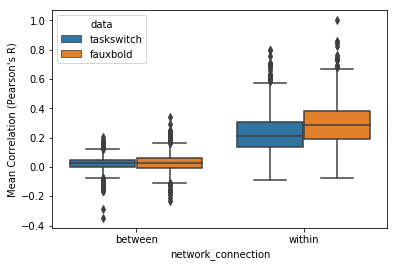

In [10]:
ax = sns.boxplot(x="network_connection", y="mean", hue='data', data=data_df)
ax.set_ylabel("Mean Correlation (Pearson's R)")

### Overall within/between network correlations do not support hypothesis 1

The average within network correlations turn out to be a little **higher** in rest relative to task, contrary to my hypothesis.
In addition, the average between network correlation does not appear to differ betweentask and rest.

### Split average within/between correlation by network
This will identify whether there are some networks during rest that have higher within network correlations relative to task and some vice versa, or if the pattern is consistent throughout.

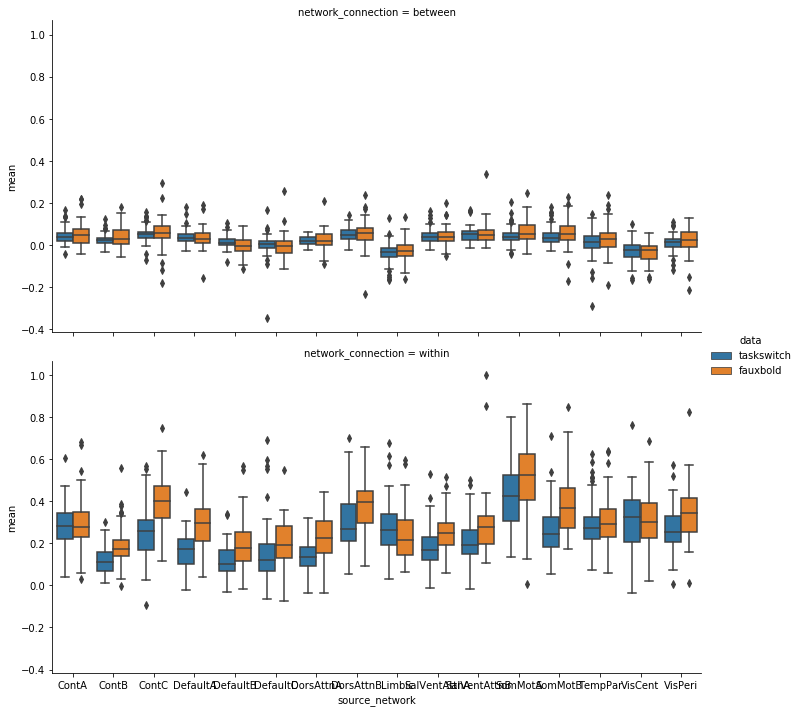

In [11]:
sns.catplot(kind='box', height=5, aspect=2,
            x='source_network', y='mean', row='network_connection',
            hue='data', data=data_df)

### Average within/between network correlation do not differ across networks
The rest within network correlations appear **higher** than the task within network correlations across all networks.

## The condition contrast within the task will be greater than the condition contrast within rest
The task had multiple trial types (single, repeat, switch).
If beta series is able to pull out differences between trial types, the difference between switch and repeat during the task should be greater than the difference between "switch" and "repeat" during rest, since no actual events occurred during rest.

In [12]:
# task (switch - repeat)
with Pool(N_THREADS) as p:
    ts_diff_matrices = p.starmap(nf.calc_diff_matrices,
                                 [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(taskswitch_switch_objs, taskswitch_repeat_objs)])

taskswitch_diff_switch_repeat = pd.concat(ts_diff_matrices)

finished GE120034
finished GE120036
finished GE120013
finished GE120026
finished GE120019
finished GE120033
finished GE120024
finished GE120025
finished GE120023
finished GE120020
finished GE120031
finished GE120032
finished GE120035
finished GE120028
finished GE120030
finished GE120017
finished GE120003
finished GE120021
finished GE120029
finished GE120004
finished GE120027
finished GE120014
finished GE120018
finished GE120011
finished GE120015
finished GE120010
finished GE120005
finished GE120001
finished GE120008
finished GE120012
finished GE120006
finished GE120002
finished GE120037
finished GE120038
finished GE120040
finished GE120039
finished GE120042
finished GE120041
finished GE120043
finished GE120049
finished GE120052
finished GE120044
finished GE120053
finished GE120050
finished GE120045
finished GE120054
finished GE120047
finished GE120056
finished GE120055
finished GE120057
finished GE120058
finished GE120061
finished GE120059
finished GE120060
finished GE120065
finished G

In [13]:
# rest (switch - repeat)
with Pool(N_THREADS) as p:
    fb_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(fauxbold_switch_objs, fauxbold_repeat_objs)])

fauxbold_diff_switch_repeat = pd.concat(fb_diff_matrices)

finished GE120028
finished GE120027
finished GE120026
finished GE120025
finished GE120030
finished GE120024
finished GE120001
finished GE120019
finished GE120008
finished GE120018
finished GE120031
finished GE120017
finished GE120036
finished GE120012
finished GE120035
finished GE120029
finished GE120023
finished GE120034
finished GE120021
finished GE120032
finished GE120015
finished GE120013
finished GE120033
finished GE120002
finished GE120011
finished GE120020
finished GE120005
finished GE120006
finished GE120003
finished GE120004
finished GE120014
finished GE120010
finished GE120037
finished GE120038
finished GE120040
finished GE120041
finished GE120039
finished GE120042
finished GE120044
finished GE120049
finished GE120047
finished GE120043
finished GE120055
finished GE120057
finished GE120050
finished GE120060
finished GE120045
finished GE120058
finished GE120059
finished GE120052
finished GE120062
finished GE120069
finished GE120063
finished GE120061
finished GE120054
finished G

In [14]:
taskswitch_diff_switch_repeat['data'] = ['taskswitch'] * taskswitch_diff_switch_repeat.shape[0]
fauxbold_diff_switch_repeat['data'] = ['fauxbold'] * fauxbold_diff_switch_repeat.shape[0]

In [15]:
diff_switch_repeat = pd.concat([taskswitch_diff_switch_repeat, fauxbold_diff_switch_repeat])
diff_switch_repeat.head()

,index,network_connection,source_network,mean,participant_id,mean_r,data
0,0,between,ContA,0.047714,GE120001,0.047678,taskswitch
1,1,between,ContB,0.052964,GE120001,0.052914,taskswitch
2,2,between,ContC,-0.029770,GE120001,-0.029762,taskswitch
3,3,between,DefaultA,-0.017391,GE120001,-0.017390,taskswitch
4,4,between,DefaultB,0.118658,GE120001,0.118104,taskswitch


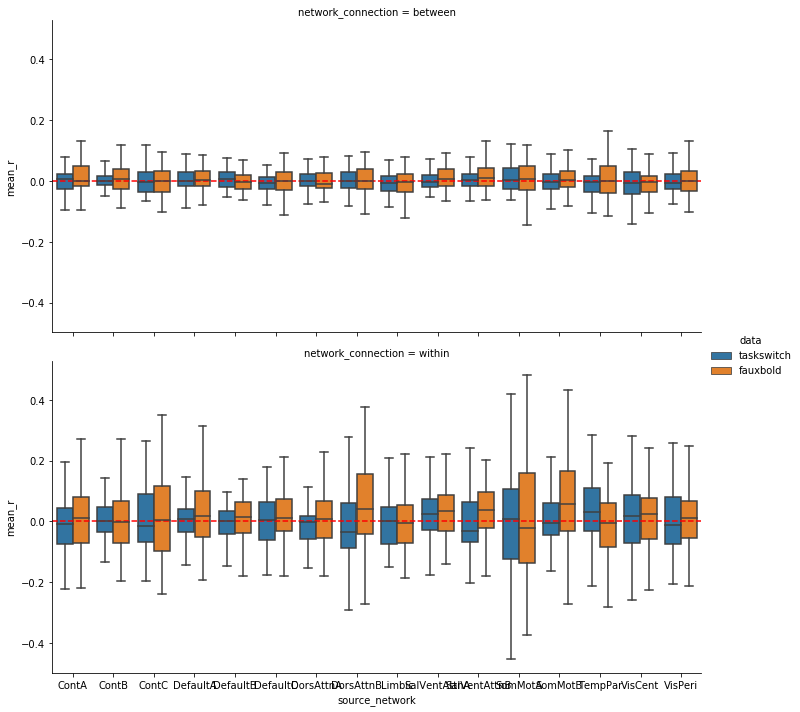

In [16]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, hue='data', data=diff_switch_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--')

## 2. The correlation contrast between task and rest will be different from zero


In [17]:
with Pool(N_THREADS) as p:
    tsf_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(taskswitch_switch_filt_objs, fauxbold_switch_objs)])


task_faux_diff_switch_repeat = pd.concat(tsf_diff_matrices)
task_faux_diff_switch_repeat.head()

finished GE120035
finished GE120036
finished GE120031
finished GE120030
finished GE120024
finished GE120021
finished GE120034
finished GE120027
finished GE120020
finished GE120029
finished GE120032
finished GE120026
finished GE120019
finished GE120033
finished GE120025
finished GE120018
finished GE120003
finished GE120028
finished GE120001
finished GE120012
finished GE120023
finished GE120017
finished GE120008
finished GE120015
finished GE120013
finished GE120010
finished GE120011
finished GE120014
finished GE120006
finished GE120004
finished GE120002
finished GE120005
finished GE120037
finished GE120039
finished GE120040
finished GE120038
finished GE120041
finished GE120042
finished GE120044
finished GE120043
finished GE120049
finished GE120053
finished GE120045
finished GE120055
finished GE120050
finished GE120058
finished GE120054
finished GE120047
finished GE120060
finished GE120057
finished GE120052
finished GE120062
finished GE120061
finished GE120065
finished GE120063
finished G

,index,network_connection,source_network,mean,participant_id,mean_r
0,0,between,ContA,0.117407,GE120001,0.116871
1,1,between,ContB,0.084203,GE120001,0.084004
2,2,between,ContC,0.012980,GE120001,0.012979
3,3,between,DefaultA,0.026345,GE120001,0.026339
4,4,between,DefaultB,0.128848,GE120001,0.128139


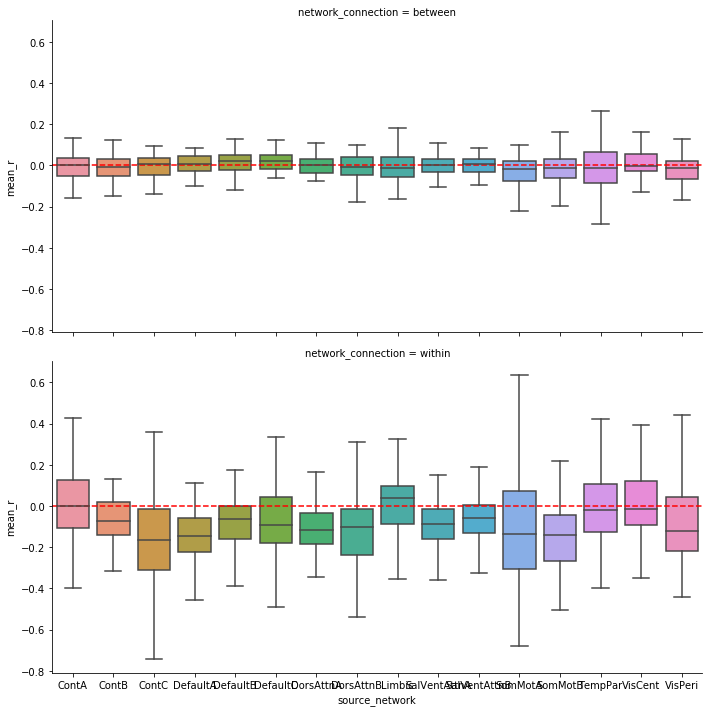

In [18]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, data=task_faux_diff_switch_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--')

In [19]:
switch_wide_df = pd.concat([nf.bind_matrices(taskswitch_switch_objs, 'taskswitch'), nf.bind_matrices(fauxbold_switch_objs, 'fauxbold')])
switch_wide_df.head()

,LH-VisCent-ExStr_1__LH-VisCent-ExStr_2,LH-VisCent-ExStr_1__LH-VisCent-ExStr_3,LH-VisCent-ExStr_1__LH-VisCent-ExStr_4,LH-VisCent-ExStr_1__LH-VisCent-ExStr_5,LH-VisCent-ExStr_1__LH-VisCent-ExStr_6,LH-VisCent-ExStr_1__LH-VisCent-ExStr_7,LH-VisCent-ExStr_1__LH-VisCent-ExStr_8,LH-VisCent-ExStr_1__LH-VisCent-ExStr_9,LH-VisCent-ExStr_1__LH-VisCent-ExStr_10,LH-VisCent-ExStr_1__LH-VisCent-ExStr_11,...,RH-TempPar-6__RH-TempPar-9,RH-TempPar-6__RH-TempPar-10,RH-TempPar-7__RH-TempPar-8,RH-TempPar-7__RH-TempPar-9,RH-TempPar-7__RH-TempPar-10,RH-TempPar-8__RH-TempPar-9,RH-TempPar-8__RH-TempPar-10,RH-TempPar-9__RH-TempPar-10,participant_id,task
0,0.315991,1.539657,1.045852,0.923111,1.055467,0.693563,0.452037,0.980423,0.523014,-0.021258,...,0.557836,0.194680,0.804195,0.803618,0.351371,0.665534,0.568753,1.073921,GE120001,taskswitch
1,0.826873,0.847774,0.645128,0.086749,0.434368,0.221788,-0.026288,0.218747,0.069924,-0.238165,...,0.757530,0.334073,1.498732,1.149092,0.638715,1.075586,0.702692,0.809416,GE120002,taskswitch
2,0.934346,0.930718,0.964107,0.833314,0.617604,0.595888,-0.193424,-0.330613,-0.309816,-0.320682,...,0.516416,0.307560,0.888054,1.034993,0.616065,0.901156,0.368418,0.923161,GE120003,taskswitch
3,0.413696,0.540163,0.739708,0.499359,0.707607,0.561109,0.068396,0.621308,0.519370,0.554776,...,-0.116669,0.172950,0.999064,-0.005146,-0.140464,0.316279,0.269674,0.515529,GE120004,taskswitch
4,0.881957,0.556033,0.770083,0.744237,0.915860,0.460484,0.536075,0.738461,0.457995,0.214080,...,0.396034,0.114421,1.030528,1.072174,0.512103,1.919318,0.999848,1.019615,GE120005,taskswitch


In [22]:
model_df = nf.model_corr_diff_mt(switch_wide_df, N_THREADS)

In [23]:
p_value_df = nf.make_symmetric_df(model_df, "p_value")
estimate_df = nf.make_symmetric_df(model_df, "estimate")
display(p_value_df.head())
display(estimate_df.head())

,ContA-LH_Cinga_1,ContA-LH_IPS_1,ContA-LH_IPS_2,ContA-LH_IPS_3,ContA-LH_IPS_4,ContA-LH_IPS_5,ContA-LH_PFCd_1,ContA-LH_PFCl_1,ContA-LH_PFCl_2,ContA-LH_PFCl_3,...,VisPeri-RH_ExStrSup_10,VisPeri-RH_ExStrSup_11,VisPeri-RH_ExStrSup_2,VisPeri-RH_ExStrSup_3,VisPeri-RH_ExStrSup_4,VisPeri-RH_ExStrSup_5,VisPeri-RH_ExStrSup_6,VisPeri-RH_ExStrSup_7,VisPeri-RH_ExStrSup_8,VisPeri-RH_ExStrSup_9
ContA-LH_Cinga_1,0.000000,0.683171,0.066982,0.025011,0.005902,0.038566,0.448106,0.259746,0.086892,0.039286,...,0.087715,0.261959,0.844929,0.318856,0.792704,0.687997,0.394152,0.021377,0.322886,0.200761
ContA-LH_IPS_1,0.683171,0.000000,0.833277,0.594778,0.426944,0.809714,0.036157,0.098170,0.354130,0.530225,...,0.529422,0.150970,0.079939,0.301221,0.034951,0.099767,0.666220,0.185719,0.409754,0.702435
ContA-LH_IPS_2,0.066982,0.833277,0.000000,0.461076,0.258900,0.555147,0.111485,0.049592,0.442403,0.902754,...,0.879713,0.315283,0.115450,0.110550,0.087256,0.218846,0.894744,0.669644,0.755397,0.886819
ContA-LH_IPS_3,0.025011,0.594778,0.461076,0.000000,0.542844,0.443437,0.377347,0.179607,0.873066,0.750723,...,0.458328,0.179919,0.082084,0.091862,0.020700,0.050225,0.662638,0.191970,0.804293,0.947724
ContA-LH_IPS_4,0.005902,0.426944,0.258900,0.542844,0.000000,0.530352,0.037513,0.066898,0.996234,0.504316,...,0.714793,0.405045,0.038543,0.037368,0.089370,0.230278,0.766301,0.517122,0.734269,0.825165


,ContA-LH_Cinga_1,ContA-LH_IPS_1,ContA-LH_IPS_2,ContA-LH_IPS_3,ContA-LH_IPS_4,ContA-LH_IPS_5,ContA-LH_PFCd_1,ContA-LH_PFCl_1,ContA-LH_PFCl_2,ContA-LH_PFCl_3,...,VisPeri-RH_ExStrSup_10,VisPeri-RH_ExStrSup_11,VisPeri-RH_ExStrSup_2,VisPeri-RH_ExStrSup_3,VisPeri-RH_ExStrSup_4,VisPeri-RH_ExStrSup_5,VisPeri-RH_ExStrSup_6,VisPeri-RH_ExStrSup_7,VisPeri-RH_ExStrSup_8,VisPeri-RH_ExStrSup_9
ContA-LH_Cinga_1,0.000000,0.056208,0.260768,0.290414,0.414680,0.311119,-0.108657,-0.163018,0.184484,0.321186,...,-0.246774,-0.124766,0.027785,0.152391,-0.035719,-0.061105,-0.128835,-0.288927,-0.147185,-0.192857
ContA-LH_IPS_1,0.056208,0.000000,-0.031207,0.079592,-0.110191,-0.033885,-0.306391,-0.253969,-0.103837,-0.086018,...,0.099763,0.196058,0.249424,0.161687,0.333284,0.259671,0.068828,0.180643,-0.120693,-0.058497
ContA-LH_IPS_2,0.260768,-0.031207,0.000000,0.113754,0.162458,0.085013,-0.271417,-0.309149,-0.090830,0.017923,...,-0.024065,0.135414,0.241781,0.249332,0.247577,0.206107,-0.021416,0.060660,-0.050128,-0.024259
ContA-LH_IPS_3,0.290414,0.079592,0.113754,0.000000,0.080884,0.100698,-0.140650,-0.218407,-0.018943,-0.042988,...,-0.115927,0.173746,0.263891,0.251697,0.359937,0.325981,0.069609,0.187282,-0.037196,0.010193
ContA-LH_IPS_4,0.414680,-0.110191,0.162458,0.080884,0.000000,-0.092063,-0.304169,-0.267567,-0.000533,-0.091700,...,-0.053244,0.094964,0.296566,0.303437,0.222772,0.172318,0.043541,0.077199,-0.047718,-0.033255


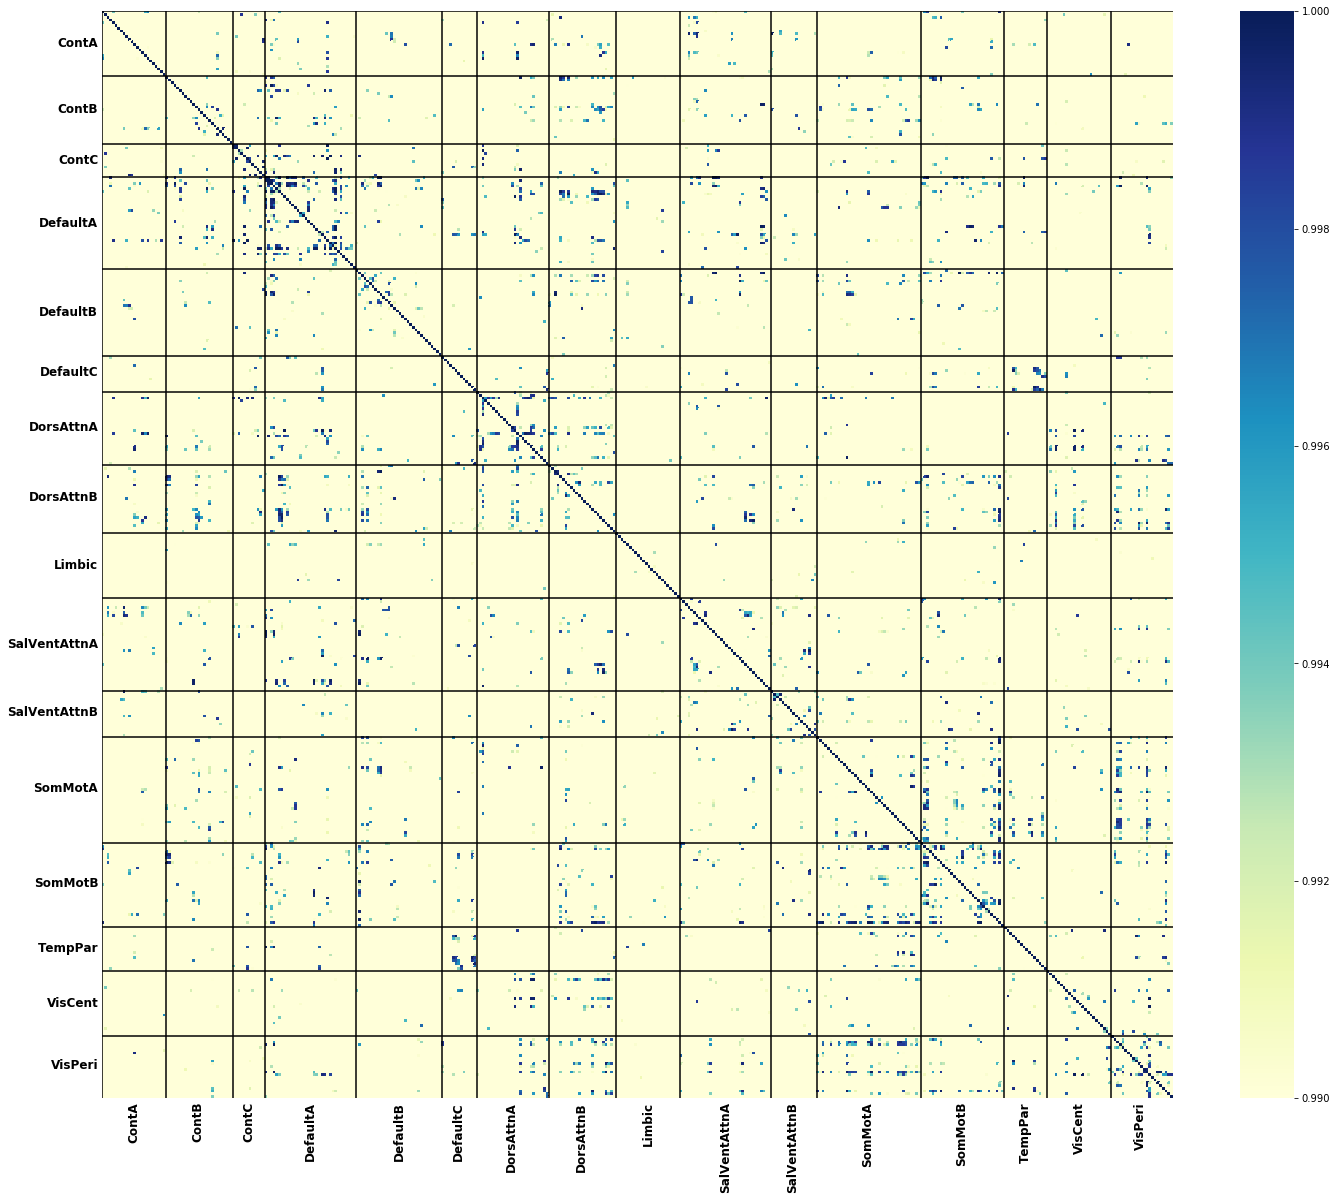

In [24]:
p_value_inv_df = 1 - p_value_df
nf._make_pretty_schaefer_heatmap(p_value_inv_df, vmin=0.99, vmax=1.0, cmap="YlGnBu")

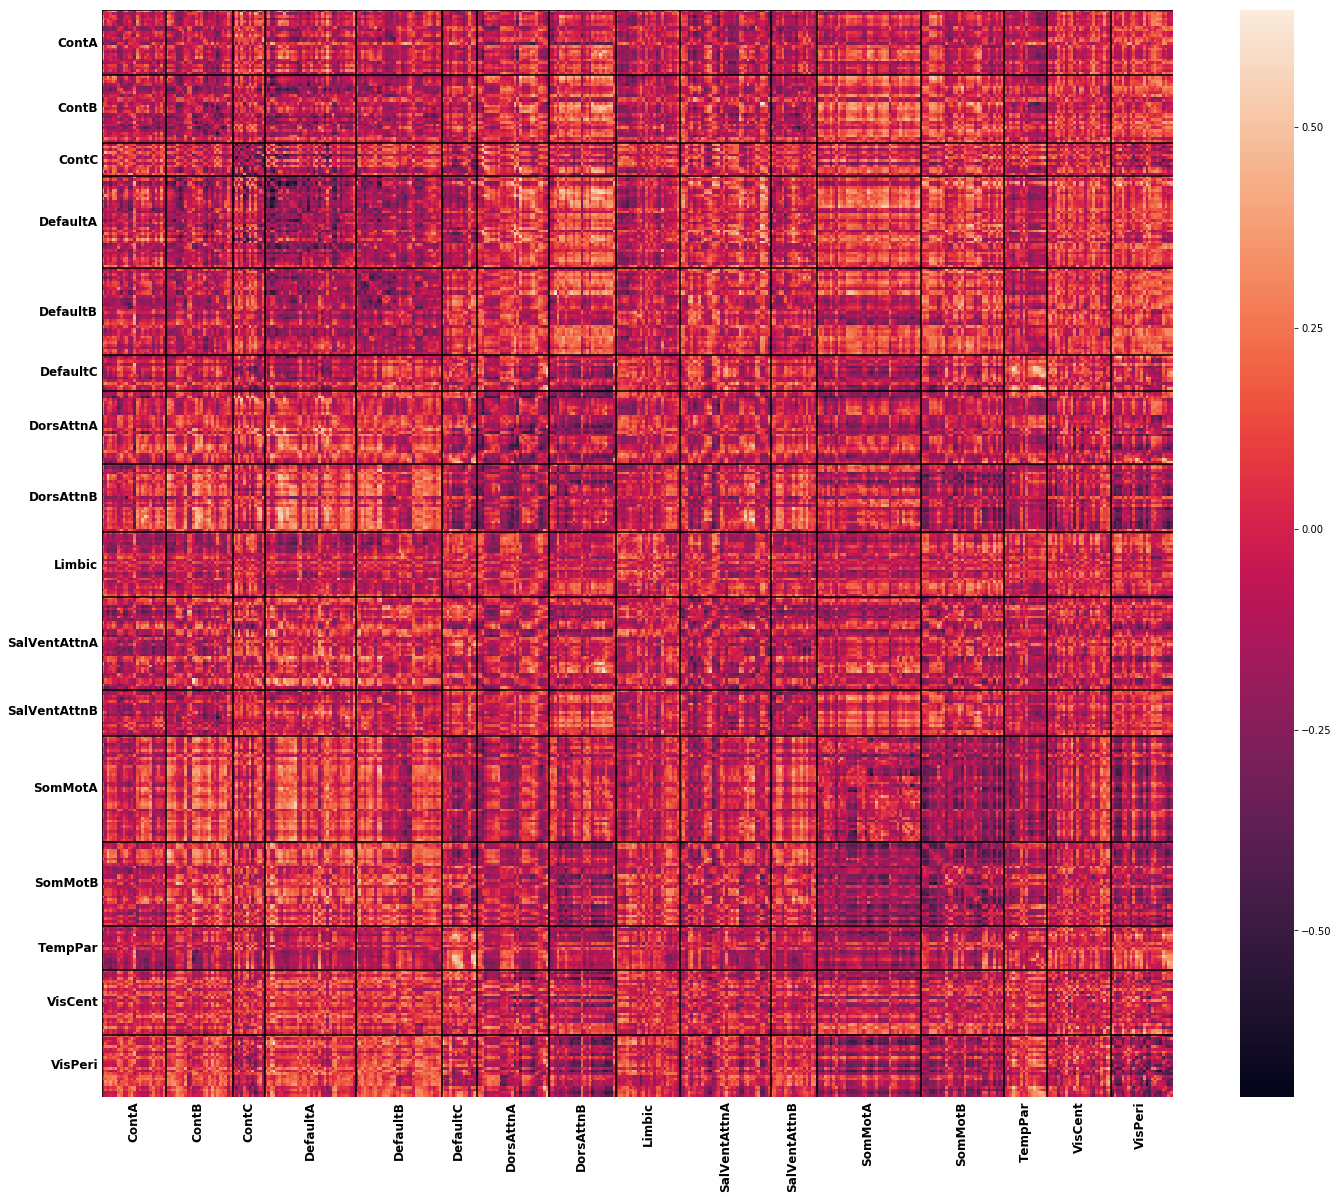

In [25]:
nf._make_pretty_schaefer_heatmap(estimate_df)

In [26]:
idxs = np.triu_indices(p_value_df.shape[0], k=1)
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_df.values[idxs], alpha=0.05, method='fdr_bh')
# only one significant p-value...
p_value_fdr[p_values_sig]

array([0.04522034])

## Participation Coefficient

In [27]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_participation_coef,
                          [(f.path, f.entities['subject'], 'taskswitch') for f in taskswitch_switch_objs])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
participant_coef_ts_df = pd.DataFrame.from_dict(dict_collector)
participant_coef_ts_df.head()

,DefaultA-LH_PCC_5_neg,DefaultA-LH_PFCm_5_pos,DorsAttnB-LH_PrCv_1_neg,SomMotA-RH_16_pos,VisCent-LH_ExStr_9_pos,TempPar-RH_3_neg,ContB-RH_PFClv_4_pos,VisCent-RH_ExStr_8_neg,SalVentAttnA-RH_Ins_2_neg,VisPeri-LH_ExStrSup_12_pos,...,ContB-LH_PFClv_2_pos,DefaultA-LH_IPL_1_neg,DorsAttnA-RH_TempOcc_3_pos,SomMotA-RH_12_neg,SomMotA-LH_14_neg,SomMotA-RH_4_neg,VisPeri-RH_ExStrSup_9_neg,DefaultB-LH_PFCl_1_neg,VisCent-LH_ExStr_3_neg,VisCent-LH_ExStr_11_pos
0,0.876066,0.902047,0.826225,0.878228,0.833331,0.886239,0.909946,0.891386,0.874016,0.913083,...,0.886882,0.890132,0.856222,0.860962,0.860332,0.856810,0.842164,0.894011,0.886563,0.898272
1,0.900248,0.885067,0.907144,0.741155,0.888454,0.896972,0.902802,0.878819,0.905397,0.914985,...,0.912446,0.889718,0.871150,0.895878,0.876353,0.842189,0.912841,0.897588,0.918284,0.900005
2,0.911246,0.887522,0.906336,0.845939,0.909105,0.901640,0.907212,0.905976,0.902093,0.913784,...,0.905167,0.920667,0.904929,0.906477,0.895011,0.893433,0.905916,0.915531,0.887863,0.917708
3,0.925535,0.899629,0.926025,0.844346,0.899031,0.923310,0.906756,0.915346,0.914771,0.921498,...,0.913139,0.923024,0.908049,0.920166,0.918414,0.915326,0.920596,0.911724,0.924666,0.905336
4,0.916014,0.901454,0.905212,0.889627,0.909471,0.903532,0.893034,0.888181,0.908458,0.916947,...,0.898061,0.921580,0.908885,0.886283,0.887401,0.910284,0.905376,0.902863,0.874806,0.865412


In [28]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_participation_coef,
                          [(f.path, f.entities['subject'], 'fauxbold') for f in fauxbold_switch_objs])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
participant_coef_fb_df = pd.DataFrame.from_dict(dict_collector)
participant_coef_fb_df.head()

,DefaultA-LH_PCC_5_neg,DefaultA-LH_PFCm_5_pos,DorsAttnB-LH_PrCv_1_neg,SomMotA-RH_16_pos,VisCent-LH_ExStr_9_pos,TempPar-RH_3_neg,ContB-RH_PFClv_4_pos,VisCent-RH_ExStr_8_neg,SalVentAttnA-RH_Ins_2_neg,VisPeri-LH_ExStrSup_12_pos,...,ContB-LH_PFClv_2_pos,DefaultA-LH_IPL_1_neg,DorsAttnA-RH_TempOcc_3_pos,SomMotA-RH_12_neg,SomMotA-LH_14_neg,SomMotA-RH_4_neg,VisPeri-RH_ExStrSup_9_neg,DefaultB-LH_PFCl_1_neg,VisCent-LH_ExStr_3_neg,VisCent-LH_ExStr_11_pos
0,0.914361,0.839714,0.839223,0.822622,0.859805,0.889801,0.877835,0.893217,0.897775,0.892820,...,0.860259,0.875561,0.867217,0.836304,0.881725,0.874612,0.891441,0.852320,0.906311,0.899947
1,0.910396,0.872042,0.874513,0.807557,0.859649,0.907848,0.909255,0.886810,0.879997,0.845490,...,0.897524,0.875740,0.817469,0.874964,0.871933,0.897201,0.869552,0.878083,0.926674,0.921490
2,0.889748,0.921786,0.885202,0.880072,0.872296,0.912904,0.923192,0.898512,0.923854,0.922072,...,0.923246,0.893897,0.859315,0.925419,0.871073,0.882934,0.909803,0.891196,0.876054,0.924528
3,0.872922,0.897042,0.876008,0.853393,0.825170,0.883474,0.905330,0.881038,0.878646,0.923605,...,0.909746,0.876601,0.892896,0.894014,0.861044,0.853917,0.877099,0.862141,0.894816,0.857789
4,0.919327,0.902079,0.830847,0.898952,0.913489,0.923689,0.919326,0.899340,0.899972,0.906499,...,0.916717,0.898803,0.919999,0.918842,0.918205,0.916927,0.890389,0.916848,0.920545,0.904026


In [29]:
participant_coef_df = pd.concat([participant_coef_ts_df, participant_coef_fb_df])
participant_coef_pos_df = participant_coef_df.filter(regex=(".*_pos|task|participant_id"))
participant_coef_neg_df = participant_coef_df.filter(regex=(".*_neg|task|participant_id"))

In [30]:
participant_coef_pos_model = nf.model_corr_diff_mt(participant_coef_pos_df, N_THREADS)

In [31]:
participant_coef_pos_model.head()

,source_target,p_value,estimate
0,SomMotA-LH_6_pos,0.619254,0.002110
1,DefaultA-LH_PFCd_3_pos,0.117654,0.007136
2,DefaultA-LH_PFCm_5_pos,0.000460,0.016085
3,SomMotA-LH_8_pos,0.759809,0.001772
4,DorsAttnB-RH_FEF_1_pos,0.421467,-0.003363


In [32]:
p_values_sig2, p_value_fdr, _, _ = multipletests(participant_coef_pos_model['p_value'], alpha=0.05, method='bonferroni')

In [33]:
participant_coef_pos_model.loc[p_values_sig2]

,source_target,p_value,estimate
49,DefaultB-RH_PFCd_4_pos,9.087176e-06,0.024428
52,TempPar-RH_4_pos,1.492788e-05,0.011273
55,DefaultA-RH_PCC_5_pos,1.077638e-04,0.020787
59,DefaultA-LH_PCC_2_pos,5.944530e-07,0.024171
64,DefaultA-LH_PCC_3_pos,9.161540e-06,0.025471
73,DorsAttnA-LH_SPL_2_pos,7.222859e-05,0.012512
74,DefaultA-LH_PCC_7_pos,1.040195e-04,0.019552
88,DefaultC-LH_Rsp_3_pos,1.113291e-06,0.015491
99,DefaultA-LH_PCC_1_pos,1.361156e-07,0.026441
104,ContC-LH_Cingp_2_pos,2.512081e-05,0.011097


In [34]:
participant_coef_df.loc[participant_coef_df['task'] == 'taskswitch', 'DefaultA-LH_PCC_3_pos'].mean()

0.9027439152747126

In [35]:
participant_coef_df.loc[participant_coef_df['task'] == 'fauxbold', 'DefaultA-LH_PCC_3_pos'].mean()

0.8772729495136022

In [36]:
participant_coef_neg_model = nf.model_corr_diff_mt(participant_coef_neg_df, N_THREADS)

In [37]:
p_values_sig3, p_value_fdr, _, _ = multipletests(participant_coef_neg_model['p_value'], alpha=0.05, method='bonferroni')

In [38]:
participant_coef_neg_model.loc[p_values_sig3]

,source_target,p_value,estimate
11,DorsAttnB-RH_PostC_8_neg,3.046305e-08,0.020045
17,DorsAttnB-RH_PostC_2_neg,1.125035e-04,0.016317
18,DefaultA-RH_PFCd_2_neg,1.128141e-04,0.011492
25,SalVentAttnA-RH_ParOper_2_neg,6.942395e-07,0.022132
30,SomMotA-LH_11_neg,5.870412e-06,0.018342
31,SalVentAttnA-RH_ParMed_3_neg,6.304162e-06,0.021164
33,VisPeri-LH_ExStrSup_11_neg,1.082930e-04,0.015997
36,DorsAttnB-LH_PostC_5_neg,1.874213e-05,0.017085
39,SomMotA-RH_17_neg,5.068394e-05,0.016768
58,SomMotA-RH_15_neg,3.396759e-06,0.016927


## Clustering Coefficient
This is a rather expensive computation

In [50]:
OVERWRITE = False
CLUSTER_TASKSWITCH_FILE = './outputs/clustering_coefficient_taskswitch_switch.tsv'
CLUSTER_FAUXBOLD_FILE = './outputs/clustering_coefficient_fauxbold_switch.tsv'

In [53]:

if os.path.isfile(CLUSTER_TASKSWITCH_FILE) and not OVERWRITE:
    clustering_coef_ts_df = pd.read_csv(CLUSTER_TASKSWITCH_FILE, sep='\t')
else:
    with Pool(N_THREADS) as p:
        sep_dicts = p.starmap(nf.calc_clustering_coef,
                              [(f.path, f.entities['subject'], 'taskswitch') for f in taskswitch_switch_objs])
        dict_collector = {
                k: [d.get(k) for d in sep_dicts]
                for k in set().union(*sep_dicts)}
    clustering_coef_ts_df = pd.DataFrame.from_dict(dict_collector)
    clustering_coef_ts_df.to_csv(CLUSTER_TASKSWITCH_FILE, sep='\t', index=False)

clustering_coef_ts_df.head()

,VisPeri-RH_ExStrSup_4,VisCent-LH_ExStr_3,DorsAttnA-RH_SPL_5,ContB-RH_Temp_2,Limbic-LH_TempPole_5,DefaultA-RH_Temp_1,SalVentAttnA-RH_ParMed_2,SalVentAttnB-RH_PFCmp_2,TempPar-RH_2,ContC-LH_Cingp_1,...,DefaultB-RH_PFCd_2,VisCent-RH_ExStr_7,SomMotB-LH_Aud_11,ContB-LH_IPL_2,SalVentAttnA-RH_Ins_5,Limbic-LH_OFC_3,DorsAttnA-LH_TempOcc_3,SomMotB-LH_Aud_2,VisPeri-RH_ExStrSup_8,DefaultA-RH_PCC_3
0,0.362208,0.371106,0.339380,0.178454,0.389071,0.320699,0.377439,0.398754,0.331046,0.152873,...,0.228696,0.320633,0.401391,0.382842,0.394885,0.336750,0.369902,0.388545,0.318492,0.319166
1,0.181942,0.147475,0.245282,0.180732,0.240937,0.222155,0.184371,0.183923,0.230529,0.186707,...,0.161093,0.124574,0.208692,0.219242,0.206274,0.169452,0.150821,0.220242,0.195187,0.158526
2,0.276204,0.265009,0.286197,0.297607,0.234139,0.253135,0.259598,0.182548,0.280494,0.205461,...,0.196349,0.205841,0.130737,0.276246,0.247298,0.145810,0.261091,0.114332,0.200658,0.277808
3,0.129624,0.162415,0.186828,0.142605,0.185703,0.190546,0.125101,0.146008,0.172882,0.166595,...,0.166029,0.172310,0.200129,0.154190,0.214064,0.141358,0.156281,0.241879,0.227460,0.158979
4,0.248221,0.169449,0.382494,0.392792,0.390487,0.395104,0.380563,0.409341,0.409540,0.211128,...,0.409617,0.388499,0.261793,0.270409,0.146322,0.394144,0.325310,0.300985,0.156966,0.342772


In [54]:
if os.path.isfile(CLUSTER_FAUXBOLD_FILE) and not OVERWRITE:
    clustering_coef_fb_df = pd.read_csv(CLUSTER_FAUXBOLD_FILE, sep='\t')
else:
    with Pool(N_THREADS) as p:
        sep_dicts = p.starmap(nf.calc_clustering_coef,
                              [(f.path, f.entities['subject'], 'fauxbold') for f in fauxbold_switch_objs])
        dict_collector = {
                k: [d.get(k) for d in sep_dicts]
                for k in set().union(*sep_dicts)}
    clustering_coef_fb_df = pd.DataFrame.from_dict(dict_collector)
    clustering_coef_fb_df.to_csv(CLUSTER_FAUXBOLD_FILE, sep='\t', index=False)
clustering_coef_fb_df.head()

,VisPeri-RH_ExStrSup_4,VisCent-LH_ExStr_3,DorsAttnA-RH_SPL_5,ContB-RH_Temp_2,Limbic-LH_TempPole_5,DefaultA-RH_Temp_1,SalVentAttnA-RH_ParMed_2,SalVentAttnB-RH_PFCmp_2,TempPar-RH_2,ContC-LH_Cingp_1,...,DefaultB-RH_PFCd_2,VisCent-RH_ExStr_7,SomMotB-LH_Aud_11,ContB-LH_IPL_2,SalVentAttnA-RH_Ins_5,Limbic-LH_OFC_3,DorsAttnA-LH_TempOcc_3,SomMotB-LH_Aud_2,VisPeri-RH_ExStrSup_8,DefaultA-RH_PCC_3
0,0.174132,0.105645,0.173397,0.149933,0.110087,0.255808,0.268275,0.243002,0.178516,0.170329,...,0.144833,0.239384,0.262037,0.176572,0.255638,0.137511,0.119612,0.187251,0.196634,0.224415
1,0.196701,0.142519,0.124975,0.265655,0.184616,0.230697,0.219798,0.213201,0.112960,0.205799,...,0.253212,0.174466,0.266695,0.181096,0.239751,0.206741,0.167573,0.140942,0.095130,0.264608
2,0.189869,0.172063,0.576622,0.582105,0.556371,0.570301,0.567797,0.568272,0.512412,0.501876,...,0.503281,0.502920,0.418894,0.568819,0.558009,0.557949,0.569018,0.509341,0.501422,0.583608
3,0.129761,0.351585,0.263464,0.328427,0.358006,0.343090,0.168942,0.333996,0.072810,0.147705,...,0.348647,0.326336,0.317989,0.261170,0.279075,0.230001,0.347267,0.183530,0.231753,0.267372
4,0.710854,0.708229,0.719495,0.719522,0.720521,0.648905,0.713721,0.715113,0.701533,0.710862,...,0.696939,0.075783,0.615366,0.716904,0.721244,0.695857,0.720132,0.164993,0.671197,0.639006


In [55]:
clustering_coef_df = pd.concat([clustering_coef_ts_df, clustering_coef_fb_df])

In [56]:
clustering_coef_model = nf.model_corr_diff_mt(clustering_coef_df, N_THREADS)
clustering_coef_model.head()

,source_target,p_value,estimate
0,ContC-RH_pCun_4,0.509668,-0.021581
1,VisPeri-RH_ExStrSup_4,0.655627,-0.013607
2,VisCent-LH_ExStr_3,0.458758,-0.024965
3,DefaultC-RH_Rsp_1,0.752912,0.010461
4,DorsAttnA-RH_SPL_5,0.912161,-0.003458


In [57]:
p_values_sig4, p_value_fdr, _, _ = multipletests(clustering_coef_model['p_value'], alpha=0.05, method='fdr_bh')

In [58]:
clustering_coef_model.loc[p_values_sig4]

,source_target,p_value,estimate


## Modularity

In [59]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_modularity,
                          [(f.path, f.entities['subject'], 'taskswitch') for f in taskswitch_switch_objs])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
modularity_ts_df = pd.DataFrame.from_dict(dict_collector)
modularity_ts_df.head()

,nan_rois,num_nan_rois,participant_id,task,ci,num_ci,modularity
0,"Index([], dtype='object')",0,GE120001,taskswitch,"[2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, ...",3,0.325561
1,"Index([], dtype='object')",0,GE120002,taskswitch,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...",4,0.413971
2,"Index([('Limbic-RH_TempPole_1',)], dtype='obje...",1,GE120003,taskswitch,"[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...",3,0.475576
3,"Index([], dtype='object')",0,GE120004,taskswitch,"[1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, ...",3,0.434739
4,"Index([], dtype='object')",0,GE120005,taskswitch,"[2, 2, 1, 1, 2, 1, 1, 1, 2, 3, 2, 2, 1, 2, 2, ...",3,0.593210


In [60]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_modularity,
                          [(f.path, f.entities['subject'], 'fauxbold') for f in fauxbold_switch_objs])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
modularity_fb_df = pd.DataFrame.from_dict(dict_collector)
modularity_fb_df.head()

,nan_rois,num_nan_rois,participant_id,task,ci,num_ci,modularity
0,"Index([], dtype='object')",0,GE120001,fauxbold,"[1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 2, 2, ...",3,0.399511
1,"Index([('Limbic-LH_TempPole_1',)], dtype='obje...",1,GE120002,fauxbold,"[2, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, ...",3,0.452589
2,"Index([('Limbic-LH_OFC_1',)], dtype='object')",1,GE120003,fauxbold,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, ...",2,0.363731
3,"Index([], dtype='object')",0,GE120004,fauxbold,"[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, ...",3,0.440663
4,"Index([('Limbic-RH_TempPole_2',)], dtype='obje...",1,GE120005,fauxbold,"[2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, ...",2,0.685215


In [61]:
modularity_df = pd.concat([modularity_ts_df, modularity_fb_df])

In [62]:
nf._run_model(modularity_df[["participant_id", "task", "modularity"]], "modularity")

{'source_target': 'modularity',
 'p_value': 0.18753022546393344,
 'estimate': 0.02082183810408878}